In [1]:
import pandas as pd
import numpy as np
from scipy import stats 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [17]:
#Load the dataset
data = pd.read_csv("C:/Users/user/Documents/Semester 4/Data Analytics/Assignment/aug_train.csv")

## Exploratory Data Analysis & Data Pre-processing

In [3]:
data.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [4]:
#Describe the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [5]:
data.describe()

,enrollee_id,city_development_index,training_hours,target
count,19158.000000,19158.000000,19158.000000,19158.000000
mean,16875.358179,0.828848,65.366896,0.249348
std,9616.292592,0.123362,60.058462,0.432647
min,1.000000,0.448000,1.000000,0.000000
25%,8554.250000,0.740000,23.000000,0.000000
50%,16982.500000,0.903000,47.000000,0.000000
75%,25169.750000,0.920000,88.000000,0.000000
max,33380.000000,0.949000,336.000000,1.000000


In [6]:
#Summary for missing values
data.isnull().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

Text(0.5, 1.0, 'Countplot of Target Feature')

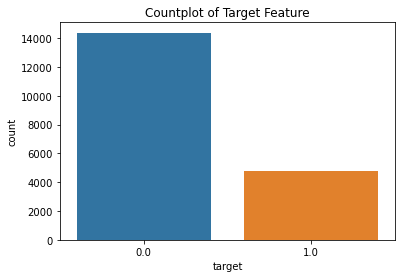

In [7]:
sns.countplot(x = 'target', data = data)
plt.title("Countplot of Target Feature")

In [18]:
#Manual mapping
def genderLabel(x):
    if x == 'Male': return 0
    elif x == 'Female':   return 1
    elif x == 'Other': return 2
    else:   return np.nan
    
def relExperienceLabel(x):
    if x == 'Has relevent experience': return 1
    else :   return 0
    
def enrollLabel(x):
    if x == 'no_enrollment'   : return 0
    elif x == 'Part time course':   return 1 
    elif x == 'Full time course':   return 2
    else : return np.nan
    
def eduLevelLabel(x):
    if x == 'Primary School'       :   return 0
    elif x == 'High School'        :   return 1 
    elif x == 'Graduate'    :   return 2 
    elif x == 'Masters'            :   return 3 
    elif x == 'Phd' :   return 4 
    else : return np.nan

def majorLabel(x):
    if x == 'STEM'                   :   return 0
    elif x == 'Business Degree'        :   return 1 
    elif x == 'Arts'                   :   return 2 
    elif x == 'Humanities'             :   return 3 
    elif x == 'No Major'               :   return 4 
    elif x == 'Other'                  :   return 5
    else : return np.nan
    
def experienceLabel(x):
    if x == '<1'      :   return 0
    elif x == '>20'       :   return 21 
    elif x is np.nan       :   return np.nan
    else       :   return int(x)
    
def companyLabel(x):
    if x == 'Pvt Ltd'               :   return 0
    elif x == 'Funded Startup'        :   return 1 
    elif x == 'Early Stage Startup'   :   return 2 
    elif x == 'Other'                 :   return 3 
    elif x == 'Public Sector'         :   return 4 
    elif x == 'NGO'                   :   return 5
    else : return np.nan 
    
def companySizeLabel(x):
    if x == '<10'          :   return 0
    elif x == '10/49'        :   return 1 
    elif x == '100-500'      :   return 2 
    elif x == '1000-4999'    :   return 3 
    elif x == '10000+'       :   return 4 
    elif x == '50-99'        :   return 5 
    elif x == '500-999'      :   return 6 
    elif x == '5000-9999'    :   return 7
    else : return np.nan
    
    
def lastJobLabel(x):
    if x == 'never'        :   return 0
    elif x == '1'            :   return 1 
    elif x == '2'            :   return 2 
    elif x == '3'            :   return 3 
    elif x == '4'            :   return 4 
    elif x == '>4'           :   return 5 
    else : return np.nan

data.gender = data.gender.apply(genderLabel)
data.relevent_experience = data.relevent_experience.apply(relExperienceLabel)
data.enrolled_university = data.enrolled_university.apply(enrollLabel) 
data.education_level = data.education_level.apply(eduLevelLabel)
data.major_discipline = data.major_discipline.apply(majorLabel)
data.experience = data.experience.apply(experienceLabel)
data.company_type = data.company_type.apply(companyLabel)
data.company_size = data.company_size.apply(companySizeLabel)
data.last_new_job = data.last_new_job.apply(lastJobLabel)

encoder = preprocessing.LabelEncoder()
data.city = encoder.fit_transform(data.city)

data.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,5,0.920,0.0,1,0.0,2.0,0.0,21.0,NaN,NaN,1.0,36,1.0
1,29725,77,0.776,0.0,0,0.0,2.0,0.0,15.0,5.0,0.0,5.0,47,0.0
2,11561,64,0.624,NaN,0,2.0,2.0,0.0,5.0,NaN,NaN,0.0,83,0.0
3,33241,14,0.789,NaN,0,NaN,2.0,1.0,0.0,NaN,0.0,0.0,52,1.0
4,666,50,0.767,0.0,1,0.0,3.0,0.0,21.0,5.0,1.0,4.0,8,0.0


Label Encoding has to be done first because Spearman Correlation Analysis requires numerical data.

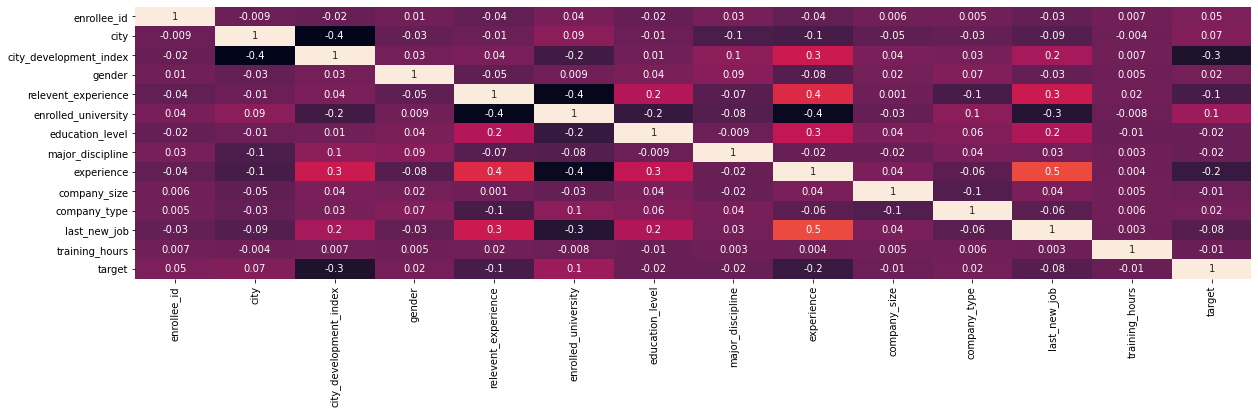

In [9]:
#Spearman correlation coefficient 
plt.figure(figsize=(20,5))
corrMatrix , p_matrix = stats.spearmanr(data, axis = 0, nan_policy = 'omit')
sns.heatmap(corrMatrix, annot = True , cbar = False, fmt = '.1g',cbar_kws = {"orientation": "horizontal"}, xticklabels = data.columns , yticklabels = data.columns)
plt.show()

In [ ]:
#Without deleting rows
X = data.drop(columns = ['target'])
y = data['target']

In [ ]:
#Delete rows
clean_data = data.dropna()
print(clean_data.shape)

In [ ]:
#Using KNN Imputation
missing_col = data.columns[data.isnull().any()].tolist()
knn_imputer = KNNImputer(n_neighbors = 3)
arr = knn_imputer.fit_transform(data.loc[:,data.columns != 'target'])
clean_data = pd.DataFrame(arr, columns = data.loc[:,data.columns != 'target'].columns)
clean_data[missing_col] = np.round(clean_data[missing_col])
clean_data['target'] = data['target'] 
clean_data.head()

In [19]:
#Apply median
data['gender'] = data['gender'].fillna((data['gender'].median()))
data['enrolled_university'] = data['enrolled_university'].fillna((data['enrolled_university'].median()))
data['education_level'] = data['education_level'].fillna((data['education_level'].median()))
data['major_discipline'] = data['major_discipline'].fillna((data['major_discipline'].median()))
data['experience'] = data['experience'].fillna((data['experience'].median()))
data['company_size'] = data['company_size'].fillna((data['company_size'].median()))
data['company_type'] = data['company_type'].fillna((data['company_type'].median()))
data['last_new_job'] = data['last_new_job'].fillna((data['last_new_job'].median()))
clean_data = data

In [20]:
#ID feature not important
clean_data = clean_data.drop(columns = ['enrollee_id', 'city'])

In [21]:
#Apply Delete Rows / KNN / Median
X = clean_data.drop(columns = ['target'])
y = clean_data['target']

In [22]:
#Handling imbalance data
sm = SMOTE(random_state = 42)
X_sm, y_sm = sm.fit_resample(X, y)
y_sm.value_counts(normalize = True) * 100

0.0    50.0
1.0    50.0
Name: target, dtype: float64

## Model Training
<br> 1. Parameters in train_test_split function is change to X and y if model does not implement SMOTE.
<br> 2. Estimator parameter in cross_val_score function is changed according to model used that time.

In [ ]:
#Train without SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [23]:
#Train with SMOTE
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size = 0.2, random_state = 42)

In [15]:
#XGBoost Classifier
xg_model = XGBClassifier()
xg_model.fit(X_train, y_train)

XGBClassifier()

In [45]:
#LightGBM Classifier
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)
print(lgb_model)

LGBMClassifier()


In [24]:
#CatBoost Classifier
cb_model = CatBoostClassifier()
cb_model.fit(X_train, y_train)

Learning rate set to 0.039306
0:	learn: 0.6747994	total: 210ms	remaining: 3m 29s
1:	learn: 0.6630921	total: 227ms	remaining: 1m 53s
2:	learn: 0.6510044	total: 243ms	remaining: 1m 20s
3:	learn: 0.6356180	total: 258ms	remaining: 1m 4s
4:	learn: 0.6240145	total: 274ms	remaining: 54.5s
5:	learn: 0.6096069	total: 289ms	remaining: 47.9s
6:	learn: 0.6010645	total: 302ms	remaining: 42.9s
7:	learn: 0.5933211	total: 318ms	remaining: 39.5s
8:	learn: 0.5858166	total: 334ms	remaining: 36.8s
9:	learn: 0.5770070	total: 348ms	remaining: 34.5s
10:	learn: 0.5693589	total: 362ms	remaining: 32.6s
11:	learn: 0.5611360	total: 377ms	remaining: 31s
12:	learn: 0.5510636	total: 391ms	remaining: 29.7s
13:	learn: 0.5447947	total: 407ms	remaining: 28.7s
14:	learn: 0.5400307	total: 423ms	remaining: 27.8s
15:	learn: 0.5355526	total: 439ms	remaining: 27s
16:	learn: 0.5300181	total: 455ms	remaining: 26.3s
17:	learn: 0.5263069	total: 468ms	remaining: 25.6s
18:	learn: 0.5207774	total: 483ms	remaining: 24.9s
19:	learn: 0

In [86]:
#Change estimator param
y_pred = cb_model.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label = 1)
print("AUC score: {:.4f}".format(metrics.auc(fpr, tpr)))
print("\nAccuracy: {:.4f}".format(metrics.accuracy_score(y_test, y_pred)))

AUC score: 0.6485

Accuracy: 0.7735


## Hyperparameter Tuning & Model Testing

In [16]:
#XGBoost Model
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

random_cv=RandomizedSearchCV(estimator=XGBClassifier(),param_distributions=params,
                             cv=5,n_iter=5,scoring='roc_auc',n_jobs=1,verbose=3,return_train_score=True,random_state=121)
random_cv.fit(X_train,y_train)
xg_bestModel = random_cv.best_estimator_

print("\n The best estimator and parameters:\n", random_cv.best_estimator_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END colsample_bytree=0.8, gamma=2, max_depth=3, min_child_weight=5, subsample=0.6;, score=(train=0.913, test=0.916) total time=   0.6s
[CV 2/5] END colsample_bytree=0.8, gamma=2, max_depth=3, min_child_weight=5, subsample=0.6;, score=(train=0.917, test=0.909) total time=   0.7s
[CV 3/5] END colsample_bytree=0.8, gamma=2, max_depth=3, min_child_weight=5, subsample=0.6;, score=(train=0.914, test=0.911) total time=   0.6s
[CV 4/5] END colsample_bytree=0.8, gamma=2, max_depth=3, min_child_weight=5, subsample=0.6;, score=(train=0.915, test=0.910) total time=   0.6s
[CV 5/5] END colsample_bytree=0.8, gamma=2, max_depth=3, min_child_weight=5, subsample=0.6;, score=(train=0.916, test=0.910) total time=   0.6s
[CV 1/5] END colsample_bytree=1.0, gamma=2, max_depth=4, min_child_weight=10, subsample=0.6;, score=(train=0.925, test=0.923) total time=   1.0s
[CV 2/5] END colsample_bytree=1.0, gamma=2, max_depth=4, min_child_weight=1

In [37]:
xg_pred = xg_model.predict(X_test)
xg_bestPred = xg_bestModel.predict(X_test)

xg_fpr, xg_tpr, thresholds = metrics.roc_curve(y_test, xg_pred, pos_label = 1)
print("AUC Score of Default",'\033[1m' + 'XGBoost Model' + '\033[0m', ": {:.4f}".format(metrics.auc(xg_fpr, xg_tpr)))
print("Accuracy: {:.4f}".format(metrics.accuracy_score(y_test, xg_pred)))
print("\nClassification Report:")
print(metrics.classification_report(y_test, xg_pred))

print("\n--------------------------------------------------------------------------\n")

xg_Bestfpr, xg_Besttpr, thresholds = metrics.roc_curve(y_test, xg_bestPred, pos_label = 1)
print("\nAUC Score of Best Model: {:.4f}" .format(metrics.auc(xg_Bestfpr, xg_Besttpr)))
print("Accuracy: {:.4f}".format(metrics.accuracy_score(y_test, xg_bestPred)))

print("\nClassification Report:")
print(metrics.classification_report(y_test, xg_bestPred))

AUC Score of Default XGBoost Model : 0.8291
Accuracy: 0.8291

Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.84      0.83      2877
         1.0       0.84      0.82      0.83      2876

    accuracy                           0.83      5753
   macro avg       0.83      0.83      0.83      5753
weighted avg       0.83      0.83      0.83      5753


--------------------------------------------------------------------------


AUC Score of Best Model: 0.8416
Accuracy: 0.8416

Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.86      0.84      2877
         1.0       0.85      0.83      0.84      2876

    accuracy                           0.84      5753
   macro avg       0.84      0.84      0.84      5753
weighted avg       0.84      0.84      0.84      5753



In [46]:
#LightGBM Model
param = {'learning_rate':[0.01, 0.1,0.2],
    'n_estimators':[10, 20,30,40],
    'max_depth':[3,5,7,9,10],
    'verbose':[-1],
    'min_data_in_leaf':[30,40,50,60,70],
    'num_leaves':[10, 20, 30]
}

modelLGBM = GridSearchCV(estimator = lgb.LGBMClassifier(), param_grid = param, cv = 5, n_jobs = -1)
modelLGBM.fit(X_train, y_train)
lgb_bestModel = modelLGBM.best_estimator_

print("\n The best estimator and parameters:\n", modelLGBM.best_estimator_)


 The best estimator and parameters:
 LGBMClassifier(learning_rate=0.2, max_depth=9, min_data_in_leaf=40,
               n_estimators=40, num_leaves=30, verbose=-1)


In [47]:
lgb_pred = lgb_model.predict(X_test)
lgb_bestPred = lgb_bestModel.predict(X_test)

lgb_fpr, lgb_tpr, thresholds = metrics.roc_curve(y_test, lgb_pred, pos_label = 1)
print("AUC Score of Default",'\033[1m' + 'LightGBM Model' + '\033[0m', ": {:.4f}".format(metrics.auc(lgb_fpr, lgb_tpr)))
print("Accuracy: {:.4f}".format(metrics.accuracy_score(y_test, lgb_pred)))
print("\nClassification Report:")
print(metrics.classification_report(y_test, lgb_pred))

print("\n--------------------------------------------------------------------------\n")

lgb_Bestfpr, lgb_Besttpr, thresholds = metrics.roc_curve(y_test, lgb_bestPred, pos_label = 1)
print("\nAUC Score of Best Model: {:.4f}" .format(metrics.auc(lgb_Bestfpr, lgb_Besttpr)))
print("Accuracy: {:.4f}".format(metrics.accuracy_score(y_test, lgb_bestPred)))

print("\nClassification Report:")
print(metrics.classification_report(y_test, lgb_bestPred))

AUC Score of Default LightGBM Model : 0.8451
Accuracy: 0.8451

Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.86      0.85      2877
         1.0       0.86      0.83      0.84      2876

    accuracy                           0.85      5753
   macro avg       0.85      0.85      0.85      5753
weighted avg       0.85      0.85      0.85      5753


--------------------------------------------------------------------------


AUC Score of Best Model: 0.8451
Accuracy: 0.8451

Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.86      0.85      2877
         1.0       0.86      0.83      0.84      2876

    accuracy                           0.85      5753
   macro avg       0.85      0.85      0.85      5753
weighted avg       0.85      0.85      0.85      5753



In [25]:
#CatBoost Model
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42)

param = {'depth'         : [6,8,10],
        'learning_rate' : [0.001, 0.025, 0.5],
        'iterations'    : [100, 500, 1000]}

modelCatBoost = GridSearchCV(estimator = CatBoostClassifier(use_best_model = True, eval_metric = 'AUC', od_type = 'Iter'), 
                             param_grid = param, cv = 5, n_jobs = -1)
modelCatBoost.fit(X_train, y_train, eval_set = (X_val, y_val))
cb_bestModel = modelCatBoost.best_estimator_

print("\n The best estimator :\n", modelCatBoost.best_estimator_)
print("\n The best parameters:\n", modelCatBoost.best_params_)

0:	test: 0.8089317	best: 0.8089317 (0)	total: 20ms	remaining: 20s
1:	test: 0.8249433	best: 0.8249433 (1)	total: 41.7ms	remaining: 20.8s
2:	test: 0.8308371	best: 0.8308371 (2)	total: 61.7ms	remaining: 20.5s
3:	test: 0.8331783	best: 0.8331783 (3)	total: 82ms	remaining: 20.4s
4:	test: 0.8405422	best: 0.8405422 (4)	total: 102ms	remaining: 20.4s
5:	test: 0.8452162	best: 0.8452162 (5)	total: 123ms	remaining: 20.4s
6:	test: 0.8458971	best: 0.8458971 (6)	total: 146ms	remaining: 20.7s
7:	test: 0.8447955	best: 0.8458971 (6)	total: 165ms	remaining: 20.5s
8:	test: 0.8443477	best: 0.8458971 (6)	total: 186ms	remaining: 20.5s
9:	test: 0.8454741	best: 0.8458971 (6)	total: 209ms	remaining: 20.7s
10:	test: 0.8466832	best: 0.8466832 (10)	total: 234ms	remaining: 21s
11:	test: 0.8474692	best: 0.8474692 (11)	total: 256ms	remaining: 21.1s
12:	test: 0.8529956	best: 0.8529956 (12)	total: 279ms	remaining: 21.2s
13:	test: 0.8548921	best: 0.8548921 (13)	total: 305ms	remaining: 21.4s
14:	test: 0.8545458	best: 0.85

In [26]:
cb_pred = cb_model.predict(X_test)
cb_bestPred = cb_bestModel.predict(X_test)

cb_fpr, cb_tpr, thresholds = metrics.roc_curve(y_test, cb_pred, pos_label = 1)
print("AUC Score of Default",'\033[1m' + 'CatBoost Model' + '\033[0m', ": {:.4f}".format(metrics.auc(cb_fpr, cb_tpr)))
print("Accuracy: {:.4f}".format(metrics.accuracy_score(y_test, cb_pred)))
print("\nClassification Report:")
print(metrics.classification_report(y_test, cb_pred))

print("\n--------------------------------------------------------------------------\n")

cb_Bestfpr, cb_Besttpr, thresholds = metrics.roc_curve(y_test, cb_bestPred, pos_label = 1)
print("\nAUC Score of Best Model: {:.4f}" .format(metrics.auc(cb_Bestfpr, cb_Besttpr)))
print("Accuracy: {:.4f}".format(metrics.accuracy_score(y_test, cb_bestPred)))

print("\nClassification Report:")
print(metrics.classification_report(y_test, cb_bestPred))

AUC Score of Default CatBoost Model : 0.8472
Accuracy: 0.8472

Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.87      0.85      2877
         1.0       0.86      0.83      0.84      2876

    accuracy                           0.85      5753
   macro avg       0.85      0.85      0.85      5753
weighted avg       0.85      0.85      0.85      5753


--------------------------------------------------------------------------


AUC Score of Best Model: 0.8488
Accuracy: 0.8488

Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.87      0.85      2877
         1.0       0.86      0.83      0.85      2876

    accuracy                           0.85      5753
   macro avg       0.85      0.85      0.85      5753
weighted avg       0.85      0.85      0.85      5753



## Model Evaluation

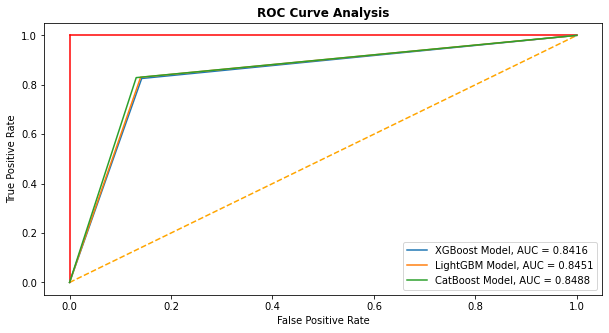

In [58]:
#Plotting the ROC Curve
fig = plt.figure(figsize=(10, 5))
plt.plot([0,1], [0,1], color = 'orange', linestyle='--')
plt.plot([0,0], [1,0], [1,1], color = 'red')
plt.plot(xg_Bestfpr, xg_Besttpr, label = "XGBoost Model, AUC = {:.4f}".format(metrics.auc(xg_Bestfpr, xg_Besttpr)))
plt.plot(lgb_Bestfpr, lgb_Besttpr, label = "LightGBM Model, AUC = {:.4f}".format(metrics.auc(lgb_Bestfpr, lgb_Besttpr)))
plt.plot(cb_Bestfpr, cb_Besttpr, label = "CatBoost Model, AUC = {:.4f}".format(metrics.auc(cb_Bestfpr, cb_Besttpr)) )
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Analysis", fontweight='bold')
plt.legend(loc='lower right')
plt.show()

## Feature Importance

In [60]:
train_pool = Pool(X_train, y_train, feature_names = list(clean_data.columns[0:11]))
cb_model.get_feature_importance(data = train_pool, type = 'LossFunctionChange', prettified = True)

,Feature Id,Importances
0,city_development_index,0.066624
1,company_size,0.047024
2,education_level,0.026695
3,last_new_job,0.025228
4,experience,0.015875
5,training_hours,0.009207
6,enrolled_university,0.007239
7,relevent_experience,0.004903
8,company_type,0.003692
9,gender,0.003552


In [27]:
baseline = pd.read_csv("C:/Users/user/Documents/Semester 4/Data Analytics/Assignment/baseline.csv")
baseline.head(5)

,index,target,prediction
0,16144,0,0
1,13661,0,0
2,344,0,0
3,1034,0,1
4,8109,0,0


In [28]:
baseline.shape

(3832, 3)

In [29]:
cb_model = pd.DataFrame(y_test)
cb_model['index'] = cb_model.index
cb_model['best_pred'] = cb_bestPred
cb_model = cb_model.drop(columns = ['target'])

In [31]:
cb_model.shape

(5753, 2)

In [32]:
overall = pd.merge(baseline, cb_model, on = 'index')

In [33]:
overall.tail(5)

,index,target,prediction,best_pred
1187,8544,1,1,1.0
1188,17873,0,0,0.0
1189,5449,0,0,0.0
1190,6480,1,1,1.0
1191,2351,0,0,0.0


In [34]:
correct_baseline = 0
incorrect_baseline = 0
correct_cbmodel = 0
incorrect_cbmodel = 0
improvement = []

for i in range(len(overall)):
    if overall.prediction[i] == overall.target[i] and overall.best_pred[i] == overall.target[i]:
        correct_baseline += 1
        correct_cbmodel += 1
        
    elif overall.prediction[i] == overall.target[i] and overall.best_pred[i] != overall.target[i]: 
        correct_baseline += 1
        incorrect_cbmodel += 1
        
    elif overall.prediction[i] != overall.target[i] and overall.best_pred[i] == overall.target[i]: 
        incorrect_baseline += 1
        correct_cbmodel += 1
        improvement.append(overall.index[i])
        
    elif overall.prediction[i] != overall.target[i] and overall.best_pred[i] != overall.target[i]: 
        incorrect_baseline += 1
        incorrect_cbmodel += 1

print("Number of Correct Baseline prediction: " , correct_baseline)
print("Number of Correct Model prediction: ", correct_cbmodel)
print("Number of Incorrect Baseline prediction: " , incorrect_baseline)
print("Number of Incorrect Model prediction: ", incorrect_cbmodel)

Number of Correct Baseline prediction:  945
Number of Correct Model prediction:  949
Number of Incorrect Baseline prediction:  247
Number of Incorrect Model prediction:  243


In [35]:
improvedPred = data.iloc[improvement, :]
improvedPred.head(5)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
49,25103,112,0.923,0.0,1,0.0,2.0,0.0,11.0,1.0,0.0,1.0,21,0.0
137,24829,5,0.920,0.0,0,0.0,3.0,3.0,3.0,4.0,0.0,1.0,133,1.0
171,12384,98,0.698,0.0,1,0.0,2.0,0.0,21.0,3.0,0.0,5.0,33,0.0
228,27667,5,0.920,0.0,0,2.0,2.0,0.0,5.0,3.0,0.0,0.0,77,0.0
291,27277,5,0.920,0.0,0,0.0,2.0,0.0,2.0,3.0,0.0,1.0,20,0.0


In these 37 observations, there are 7 candidates that intend to change job. Hence, we would look at the characteristics exhibit by these candidates in the top 5 features.

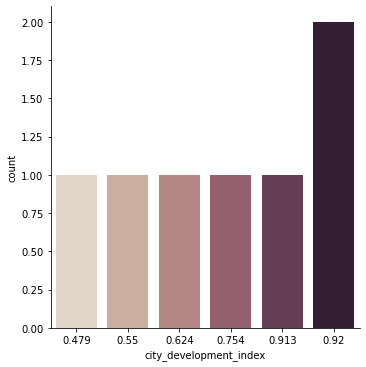

In [41]:
improvedPred = improvedPred[improvedPred['target'] == 1]
sns.catplot(x = "city_development_index", kind = "count", palette = "ch:.25", data = improvedPred)

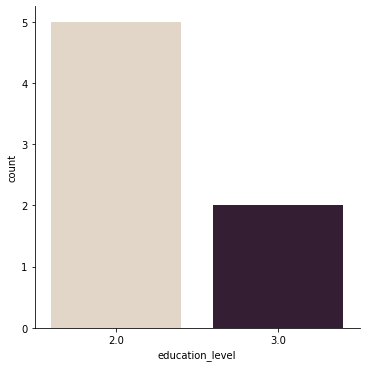

In [45]:
sns.catplot(x = "education_level", kind = "count", palette = "ch:.25", data = improvedPred)

# 2 = Graduates and 3 = Masters

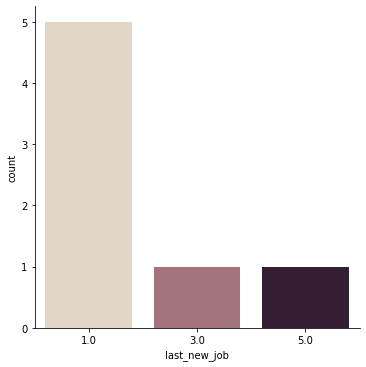

In [44]:
sns.catplot(x = "last_new_job", kind = "count", palette = "ch:.25", data = improvedPred)